# Setup

In [464]:
import warnings
warnings.simplefilter("ignore")

In [465]:
try:
  import geopandas as gpd
except ModuleNotFoundError as e:
  !pip install geopandas==0.12.1
  import geopandas as gpd

if gpd.__version__ != "0.12.1":
  !pip install -U geopandas==0.12.1
  import geopandas as gpd

In [466]:
try:
  import rasterio as rio
except ModuleNotFoundError as e:
  !pip install rasterio==1.3.4
  import rasterio as rio

if rio.__version__ != "1.3.4":
  !pip install -U rasterio==1.3.4
  import rasterio as rio

In [467]:
try:
  import xarray as xr
except ModuleNotFoundError as e:
  !pip install xarray-spatial==0.3.5
  import xarray as xr

if xr.__version__ != "0.3.5":
  !pip install -U xarray-spatial==0.3.5
  import xarray as xr

Defaulting to user installation because normal site-packages is not writeable


In [468]:
try:
  import rtxpy
except ModuleNotFoundError as e:
  !pip install rtxpy==0.0.3
  import rtxpy 


In [469]:
try:
    import spatialpandas
except ModuleNotFoundError as e:
    !pip install spatialpandas==0.4.4
    import spatialpandas

if spatialpandas.__version__ != "0.4.4":
    !pip install -U spatialpandas==0.4.4
    import spatialpandas

In [470]:
try:
    import numba
except ModuleNotFoundError as e:
    !pip install numba==0.56.4
    import numba

if numba.__version__ != "0.56.4":
    !pip install -U numba==0.56.4
    import numba

In [471]:
try:
  import owslib
except ModuleNotFoundError as e:
  !pip install owslib==0.27.2
  import owslib

In [472]:
from matplotlib import pyplot as plt

# Exercises
- clip the area with the shape of Polo Ferrari (in front on FBK)
- create the altitude profile of the street "Via Sommarive"
- find the area FBK in the WMS of municipality of Trento - layer "Carta Tecnica 1:2.000 alta risoluzione" and vectorize it
- identify what is possibile to see from the crossing point between Via Sommarive and Via dei Valoni
---


## clip the area with the shape of Polo Ferrari (in front on FBK)
1. identify the area of Polo Ferrari
2. download the raster of scientific hub in Povo
3. clip area

In [473]:
import geopandas as gpd
import rasterio 
from rasterio.mask import mask
from rasterio.plot import show

### 1. identify the area of Polo Ferrari

![](https://raw.githubusercontent.com/napo/geospatial_course_unitn/master/images/polo_ferrari_overpassturbo.png)

[http://overpass-turbo.eu/s/ZzP](http://overpass-turbo.eu/s/ZzP
)

[geojson](https://raw.githubusercontent.com/napo/geospatial_course_unitn/master/data/openstreetmap/polo_ferrari_boundary.geojson)



In [474]:
geojson_polo_ferarri = "https://raw.githubusercontent.com/napo/geospatial_course_unitn/master/data/openstreetmap/polo_ferrari_boundary.geojson"

In [475]:
polo_ferrari = gpd.read_file(geojson_polo_ferarri)

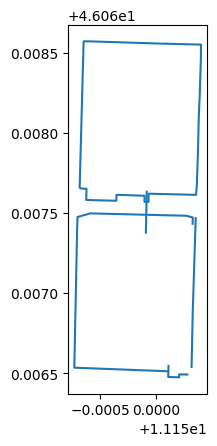

In [476]:
polo_ferrari.plot()
plt.show()

In [477]:
polo_ferrari.geometry.type.unique()

array(['LineString'], dtype=object)

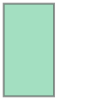

In [478]:
polo_ferrari.geometry.unary_union.envelope

In [479]:
area_polo_ferrari = polo_ferrari.geometry.unary_union.envelope

In [480]:
type(area_polo_ferrari)

shapely.geometry.polygon.Polygon

### 2. download the raster of scientific hub in Povo


In [481]:
url_download_orthophoto_scientific_hub_povo = 'https://github.com/napo/geospatial_course_unitn/raw/master/data/raster/trento_scientifc_hub_povo.tif'

In [482]:
raster = rasterio.open(url_download_orthophoto_scientific_hub_povo)

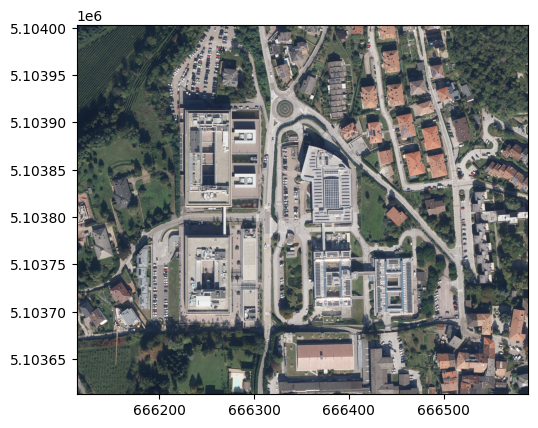

<AxesSubplot:>

In [483]:
show(raster)

In [484]:
raster.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 4761,
 'height': 3900,
 'count': 3,
 'crs': CRS.from_epsg(25832),
 'transform': Affine(0.09999999999999999, 0.0, 666113.0,
        0.0, -0.09999999999999999, 5104003.0)}

### 3. clip area

In [485]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]


In [486]:
gdf_polo_ferrari_25832 = gpd.GeoSeries([area_polo_ferrari]).set_crs("EPSG:4326").to_crs("EPSG:25832")

In [487]:
coords = getFeatures(gdf_polo_ferrari_25832)

In [488]:
coords

[{'type': 'Polygon',
  'coordinates': [[[666221.9300357221, 5103679.093307299],
    [666310.1180686228, 5103681.477369573],
    [666303.8138183787, 5103914.6097356975],
    [666215.6291314249, 5103912.225679764],
    [666221.9300357221, 5103679.093307299]]]}]

In [489]:
raster_polo_ferrari, raster_polo_ferrari_transform = mask(raster, coords, crop=True)

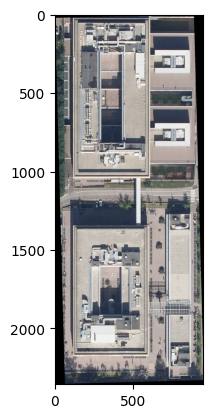

<AxesSubplot:>

In [490]:
show(raster_polo_ferrari)

In [491]:
raster_polo_ferrari_meta = raster.meta

In [492]:
raster_polo_ferrari_meta.update({"driver": "GTiff",
                 "height": raster_polo_ferrari.shape[1],
                 "width": raster_polo_ferrari.shape[2],
                 "transform": raster_polo_ferrari_transform})

with rasterio.open("polo_ferrari_orthophoto.tif", "w", **raster_polo_ferrari_meta) as dest:
    dest.write(raster_polo_ferrari)

In [493]:
#uncomment if you want download with colab
#from google.colab import files
#files.download('polo_ferrari_orthophoto.tif')

## create the altitude profile of the street “Via Sommarive”
1. download the street "Via Sommarive" from OpenStreetMap
1. download the DTM file of the scientific hub of Povo
1. clip the street inside the area covered of the DTM
1. extract the points of the street
1. extract the altitude value for each points
1. show the altitude
---


### 1. download the street "Via Sommarive" from OpenStreetMap

![](https://raw.githubusercontent.com/napo/geospatial_course_unitn/master/images/via_sommarive_overpassturbo.png)

[](http://overpass-turbo.eu/s/ZA0)

[geojson](https://raw.githubusercontent.com/napo/geospatial_course_unitn/master/data/openstreetmap/via_sommarive.geojson)

In [494]:
via_sommarive = gpd.read_file("https://raw.githubusercontent.com/napo/geospatial_course_unitn/master/data/openstreetmap/via_sommarive.geojson")

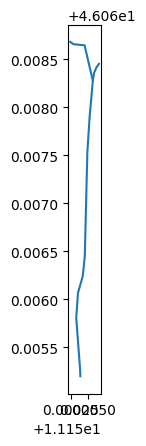

In [495]:
via_sommarive.plot()
plt.show()

### 2. download the DTM file of the scientific hub of Povo

In [496]:
import urllib.request
url_download_dtm_scientific_hub_povo = 'https://github.com/napo/geospatial_course_unitn/raw/master/data/raster/trento_scientifc_hub_povo_dtm.asc'
dtm = "trento_scientifc_hub_povo_dtm.asc"
urllib.request.urlretrieve(url_download_dtm_scientific_hub_povo ,dtm) 
url_download_dtm_scientific_hub_povo_prj = 'https://github.com/napo/geospatial_course_unitn/raw/master/data/raster/trento_scientifc_hub_povo_dtm.prj'
dtm_prj = "trento_scientifc_hub_povo_dtm.prj"
urllib.request.urlretrieve(url_download_dtm_scientific_hub_povo_prj ,dtm_prj) 

('trento_scientifc_hub_povo_dtm.prj',
 <http.client.HTTPMessage at 0x7f99f94bfca0>)

In [497]:
dtm = "trento_scientifc_hub_povo_dtm.asc"

In [498]:
raster_dtm = rasterio.open(dtm)

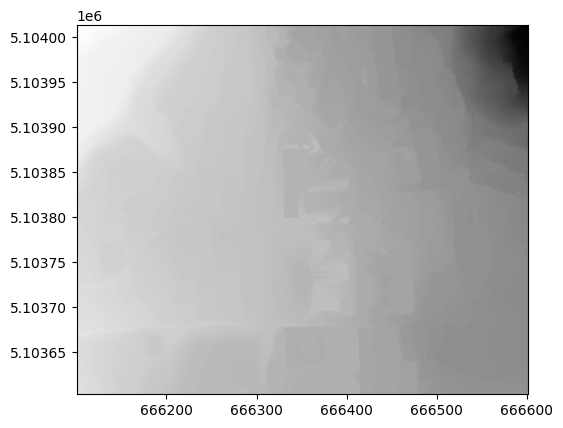

<AxesSubplot:>

In [499]:
show(raster_dtm, cmap='Greys')

### 3. clip the street inside the area covered of the DTM

In [500]:
raster_dtm.bounds

BoundingBox(left=666100.6735466761, bottom=5103603.23583161, right=666600.6735466761, top=5104013.23583161)

In [501]:
minx = raster_dtm.bounds.left
maxx = raster_dtm.bounds.right
miny = raster_dtm.bounds.bottom
maxy = raster_dtm.bounds.top


![](https://raw.githubusercontent.com/napo/geospatial_course_unitn/master/images/boudingbox.png)

In [502]:
from shapely.geometry import Polygon

In [503]:
bbox_raster_dtm = Polygon([[minx, miny], [maxx, miny], [maxx, maxy], [minx, maxy]])

In [504]:
geoseries_bbox_raster_dtm = gpd.GeoSeries([bbox_raster_dtm]).set_crs("EPSG:25832").to_crs("EPSG:4326")

In [505]:
geoseries_bbox_raster_dtm

0    POLYGON ((11.14767 46.06582, 11.15413 46.06570...
dtype: geometry

In [506]:
gdf_bbox_raster_dtm = gpd.GeoDataFrame(geometry=geoseries_bbox_raster_dtm)

In [507]:
gdf_bbox_raster_dtm

,geometry
0,"POLYGON ((11.14767 46.06582, 11.15413 46.06570..."


In [508]:
sommarive_street_inside_dtm = gpd.overlay(via_sommarive, gdf_bbox_raster_dtm, how='intersection')

In [509]:
sommarive_street_inside_dtm

,id,@id,highway,lit,maxspeed,maxspeed:type,name,source:maxspeed,surface,geometry
0,way/97004470,way/97004470,unclassified,yes,None,IT:urban,Via Sommarive,None,asphalt,"LINESTRING (11.15033 46.06577, 11.15033 46.065..."
1,way/382958545,way/382958545,residential,None,50,None,Via Sommarive,sign,asphalt,"LINESTRING (11.15058 46.06828, 11.15045 46.068..."


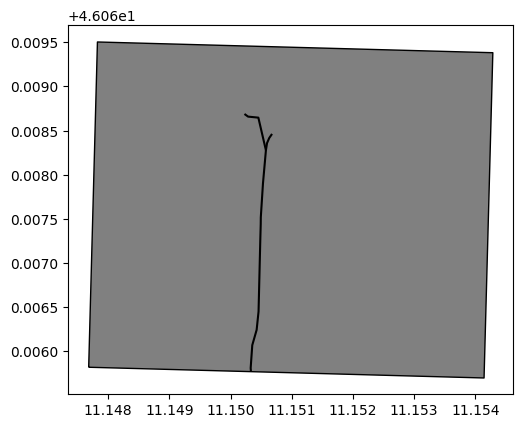

In [510]:
fig, ax = plt.subplots()
sommarive_street_inside_dtm.plot(ax=ax, color='black', edgecolor='black')
gdf_bbox_raster_dtm.plot(ax=ax, color='gray', edgecolor='black')
plt.show();

In [511]:
sommarive_street_inside_dtm.highway

0    unclassified
1     residential
Name: highway, dtype: object

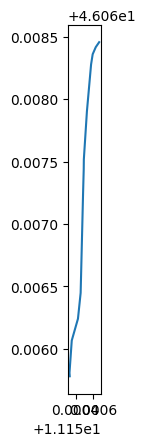

In [512]:
sommarive_street_inside_dtm[sommarive_street_inside_dtm.highway == 'unclassified'].plot()
plt.show()

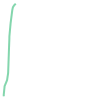

In [513]:
sommarive_street_inside_dtm[sommarive_street_inside_dtm.highway == 'unclassified'].geometry.values[0]

In [514]:
linestring_sommarive_street = sommarive_street_inside_dtm[sommarive_street_inside_dtm.highway == 'unclassified'].geometry.values[0]

### 4. extract the points of the street
we need to convert the points from WGS84 to ETRS89

In [515]:
import shapely
import pyproj
from shapely.ops import transform

In [516]:
wgs84 = pyproj.CRS('EPSG:4326')
crs_dtm = pyproj.CRS('EPSG:25832')
projection_transform = pyproj.Transformer.from_crs(wgs84, crs_dtm, always_xy=False).transform

In [517]:
def convert(x,y):
  p = shapely.geometry.Point(y,x)
  p = transform(projection_transform,p)
  return(p)

In [518]:
pointsx = []
pointsy = []
for coordinate in linestring_sommarive_street.coords:
  x = coordinate[0]
  y = coordinate[1]
  point = convert(x,y)
  pointsx.append(point.x)
  pointsy.append(point.y)

In [519]:
pointsx[0]

666306.4552006973

In [520]:
pointsy[0]

5103603.230911811

### 4. extract the altitude value for each points

In [521]:
import pandas as pd

In [522]:
#calculate the distance point-to-point
from shapely.geometry import Point,LineString
lengths = []
previousPoint = None
length = 0
for i in range(len(pointsx)):
  point = shapely.geometry.Point(pointsy[i],pointsx[i])
  if previousPoint is None:
    lengths.append(length)
  else:
    length = LineString([previousPoint,point]).length + length
    lengths.append(length)  
  previousPoint = point 


In [523]:
lengths

[0,
 3.951209708453172,
 32.831459095104734,
 52.980608611161294,
 76.08957728511274,
 92.85559295820157,
 165.21088895086632,
 186.20305604139205,
 194.89525292991763,
 237.73013209200536,
 279.6642269476137,
 288.7776897544056,
 295.68268594259496,
 301.98476544905714]

In [524]:
raster_dtm.count

1

In [525]:
data = raster_dtm.read(1)

In [526]:
data

array([[335., 335., 335., ..., 468., 469., 469.],
       [334., 334., 334., ..., 469., 469., 469.],
       [334., 334., 334., ..., 469., 469., 469.],
       ...,
       [357., 357., 357., ..., 400., 400., 401.],
       [356., 357., 357., ..., 400., 400., 400.],
       [356., 357., 357., ..., 400., 400., 400.]], dtype=float32)

In [527]:
rows,cols = rasterio.transform.rowcol(raster_dtm.transform,(pointsx),(pointsy))

In [528]:
values = []
for i in range(len(rows)):
  values.append(data[rows[i]-1][cols[i]-1]) 

In [529]:
values

[382.0,
 382.0,
 380.0,
 378.0,
 378.0,
 378.0,
 378.0,
 378.0,
 378.0,
 378.0,
 380.0,
 380.0,
 381.0,
 381.0]

In [530]:
sommarive_street_3d = pd.DataFrame()

In [531]:
sommarive_street_3d['value'] = values

In [532]:
sommarive_street_3d['length'] = lengths

In [533]:
sommarive_street_3d

,value,length
0,382.0,0.000000
1,382.0,3.951210
2,380.0,32.831459
3,378.0,52.980609
4,378.0,76.089577
5,378.0,92.855593
6,378.0,165.210889
7,378.0,186.203056
8,378.0,194.895253
9,378.0,237.730132


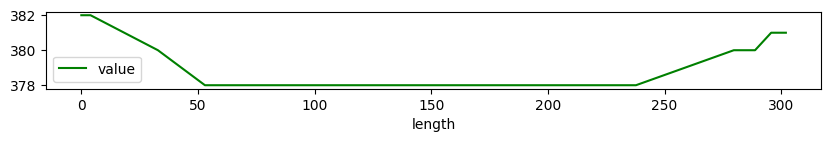

In [534]:
ax = sommarive_street_3d.plot(y='value',x="length",color='green',figsize=(10,1))
plt.show()

## find the area FBK in the WMS of municipality of Trento - layer “Carta Tecnica 1:2.000 alta risoluzione” and vectorize it

1. create a bounding box based on the FBK area in Povo
1. load the WMS of muncipality of Trento as rasterio on the size of the bounding box
1. vectorize the rasterio
---


### 1. create a bounding box based on the FBK area in Povo
.. we can use the same geojson extracted from OSM used on the lesson

In [535]:
fbk = gpd.read_file("https://raw.githubusercontent.com/napo/geospatial_course_unitn/master/data/openstreetmap/boundary_fbk_povo.geojson")

In [536]:
bbox = fbk.geometry[0].bounds

In [537]:
bbox

(11.1505197, 46.0664359, 11.1530713, 46.0684635)

In [538]:
fbk.shape

(1, 10)

### 2. load the WMS of muncipality of Trento as rasterio on the size of the bounding box

In [539]:
from owslib.wms import WebMapService
import rasterio.crs

In [540]:
wms_trento = "http://webapps.comune.trento.it/ogc"
wms = WebMapService(wms_trento)

In [541]:
title="Carta Tecnica 1:2.000 alta risoluzione a colori"

In [542]:
for content in wms.contents:
  layer = wms[content]
  if layer.title == title:
    break

In [543]:
content

'ct2000_colori'

In [544]:
layer.crsOptions

['EPSG:3857', 'EPSG:25832', 'EPSG:4326']

In [545]:
request = wms.getmap(
    layers=[content],
    srs='EPSG:4326',
    format='image/tiff',
    bbox=bbox,
    size=(1024,800)
    )

In [546]:
from rasterio import MemoryFile
from rasterio.plot import show
from rasterio import features

In [547]:
wms_image = MemoryFile(request).open()

In [548]:
wms_image.profile

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 1024, 'height': 800, 'count': 3, 'crs': CRS.from_epsg(4326), 'transform': Affine(2.4917968750015575e-06, 0.0, 11.1505197,
       0.0, -2.5344999999997646e-06, 46.0684635), 'blockysize': 2, 'tiled': False, 'interleave': 'pixel'}

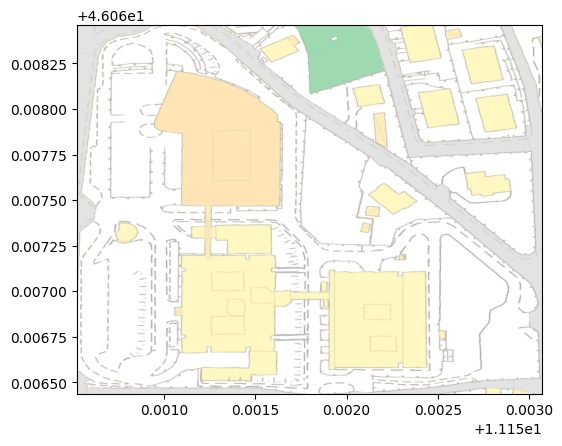

<AxesSubplot:>

In [549]:
show(wms_image)

In [550]:
wms_image.count

3

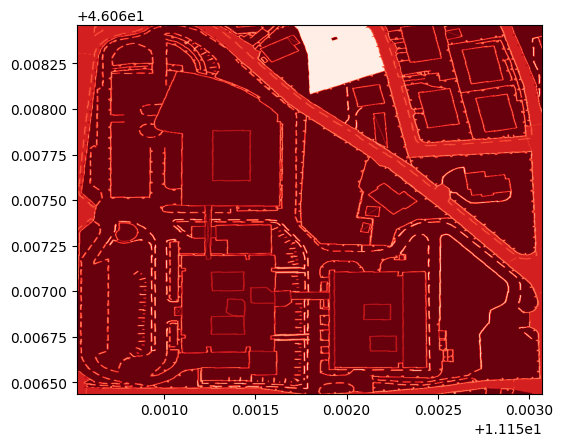

<AxesSubplot:>

In [551]:
show((wms_image, 1), cmap='Reds')

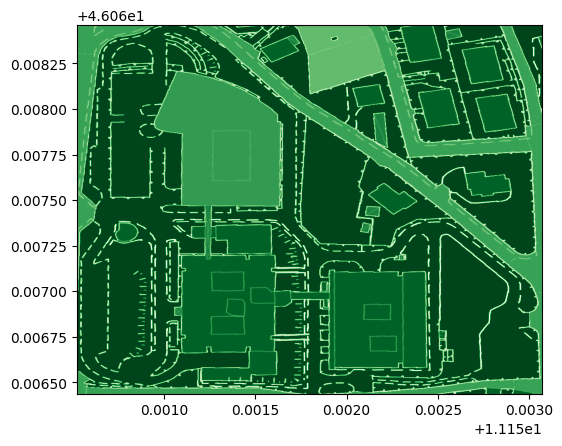

<AxesSubplot:>

In [552]:
show((wms_image, 2), cmap='Greens')

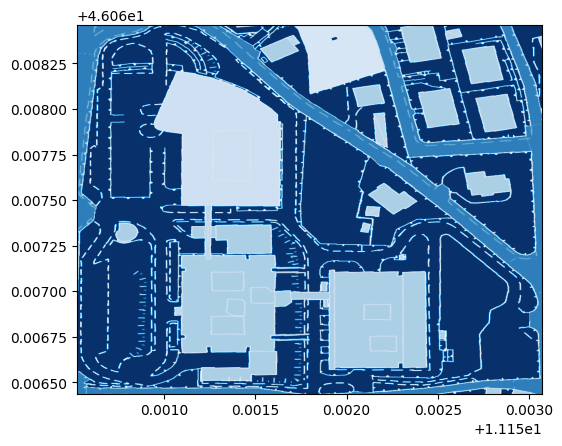

<AxesSubplot:>

In [553]:
show((wms_image, 3), cmap='Blues')

In [554]:
from rasterio.features import shapes
image = wms_image.read(3) # first band
mask = image != 255
results = (
  {'properties': {'raster_val': v}, 'geometry': s}
  for i, (s, v) 
    in enumerate(
      shapes(image, mask=mask, transform=wms_image.transform)))

In [555]:
geoms = list(results)

In [556]:
fbk_area_vector  = gpd.GeoDataFrame.from_features(geoms)

In [557]:
fbk_area_vector.shape

(78339, 2)

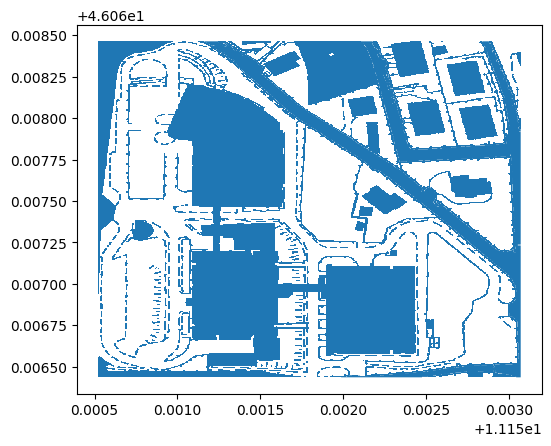

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 7.39 µs


In [558]:
fbk_area_vector.plot()
plt.show()
%time

FBK Buildings

- [North](https://www.openstreetmap.org/?mlat=46.06782&mlon=11.15156#map=19/46.06782/11.15156)
- [West](https://www.openstreetmap.org/?mlat=46.06689&mlon=11.15116#map=19/46.06689/11.15116)
- [East](https://www.openstreetmap.org/?mlat=46.06684&mlon=11.15200#map=19/46.06684/11.15200)

In [559]:
p_north = shapely.geometry.Point(11.15156,46.06782)

In [560]:
building_north = fbk_area_vector[fbk_area_vector.geometry.contains(p_north)]

In [561]:
building_north

,geometry,raster_val
42228,"POLYGON ((11.15107 46.06820, 11.15108 46.06820...",181.0


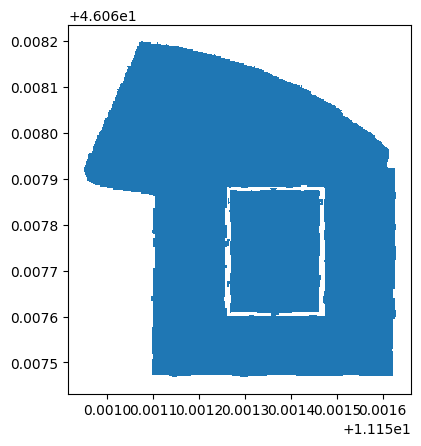

In [562]:
building_north.plot()
plt.show()

In [563]:
p_west = shapely.geometry.Point(11.15116,46.06689)
building_west = fbk_area_vector[fbk_area_vector.geometry.contains(p_west)]

In [564]:
p_east = shapely.geometry.Point(11.15200,46.06684)
building_east = fbk_area_vector[fbk_area_vector.geometry.contains(p_east)]

In [565]:
building_east

,geometry,raster_val
70295,"POLYGON ((11.15198 46.06710, 11.15200 46.06710...",193.0


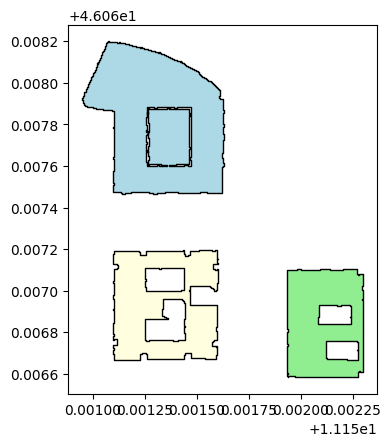

In [566]:
fig, ax = plt.subplots()
building_north.plot(ax=ax, color='lightblue', edgecolor='black')
building_west.plot(ax=ax, color='lightyellow', edgecolor='black')
building_east.plot(ax=ax, color='lightgreen', edgecolor='black')
plt.show();

## Identify what is possibile to see from the crossing point between Via Sommarive and Via dei Valoni

1. identify the crossing point between Via Sommarive and Via dei Valoni
1. calculate the viewshed by using the DTM
1. visualize it
---
for this operation we will use:
- [xarray-spatial](https://xarray-spatial.org/)<Br/>
xarray-spatial is a package for raster-based spatial analytics<br/>
among the supported functions there is the [viewshed](https://xarray-spatial.org/v0.0.5/viewshed.html)<br/>The function returns *A cell x in the visibility grid is recorded as follows: If it is invisible, then x is set to INVISIBLE. If it is visible, then x is set to the vertical angle w.r.t the viewpoint*



In [567]:
import xarray as xr
import numpy as np

from xrspatial import hillshade
from xrspatial import viewshed

**Visualize** input data

We'll compute hillshade of the raster to better understand it.

In [568]:
file_name = 'trento_scientifc_hub_povo_dtm.asc'
raster = xr.open_rasterio(file_name).sel(band=1).drop('band', dim=None)
raster.name = 'elevation'

xmin, xmax = raster.x.data.min(), raster.x.data.max()
ymin, ymax = raster.y.data.min(), raster.y.data.max()

xmin, xmax, ymin, ymax

(666101.1735466761, 666600.1735466761, 5103603.73583161, 5104012.73583161)

In [569]:
illuminated = hillshade(raster, name='Hillshade')

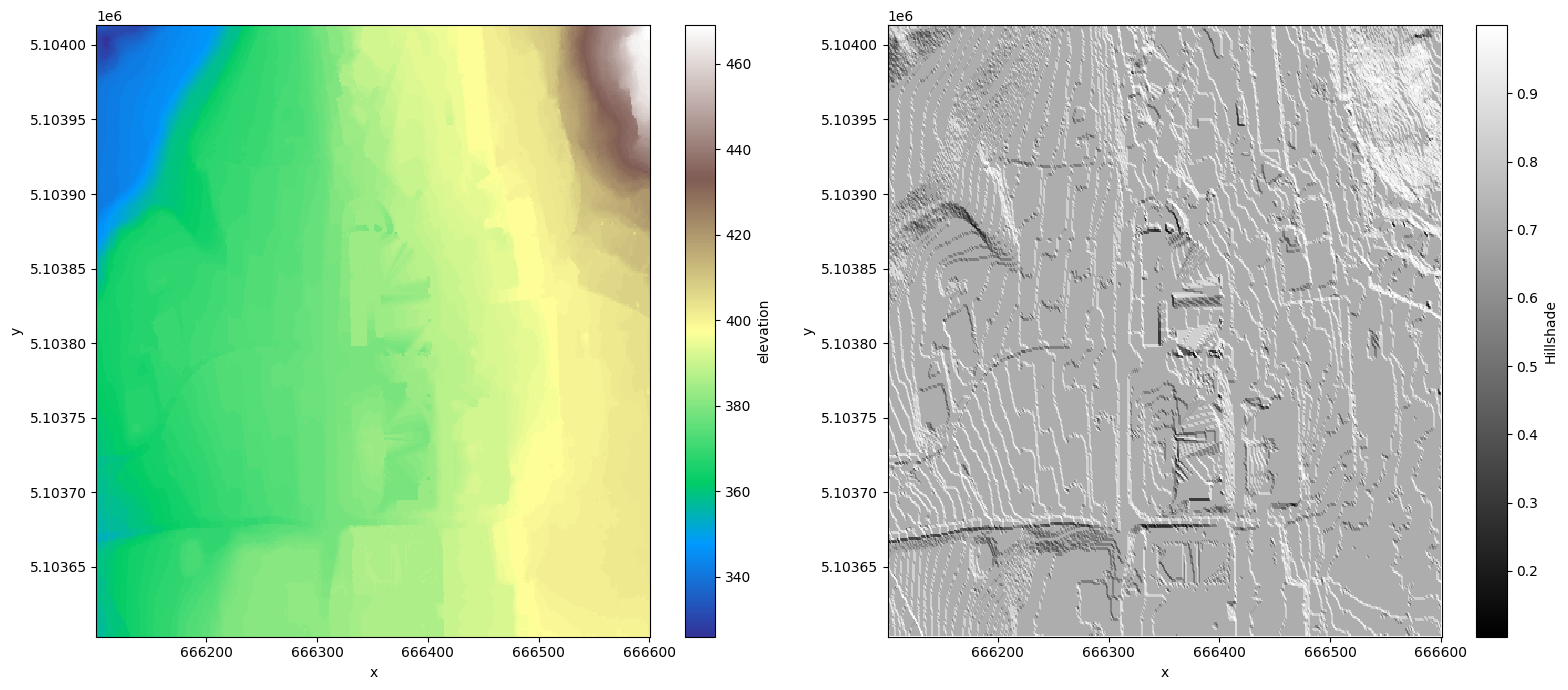

In [570]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 7))
raster.plot.imshow(ax=ax1, cmap='terrain')
illuminated.plot.imshow(ax=ax2, cmap='gray')
plt.tight_layout()

### identify the crossing point between Via Sommarive and Via dei Valoni

we have already via Sommarive

In [571]:
via_sommarive

,id,@id,highway,lit,maxspeed,maxspeed:type,name,source:maxspeed,surface,geometry
0,way/97004470,way/97004470,unclassified,yes,None,IT:urban,Via Sommarive,None,asphalt,"LINESTRING (11.15039 46.06519, 11.15039 46.065..."
1,way/382958545,way/382958545,residential,None,50,None,Via Sommarive,sign,asphalt,"LINESTRING (11.15058 46.06828, 11.15045 46.068..."


... and we download Via dei Valóni - [overpass-turbo](https://overpass-turbo.eu/s/1ob9)<br/>
You can download the file [here](https://github.com/napo/geospatial_course_unitn/raw/master/data/openstreetmap/via_valoni.geojson)

In [572]:
via_valoni = gpd.read_file("https://github.com/napo/geospatial_course_unitn/raw/master/data/openstreetmap/via_valoni.geojson")

In [573]:
intersection = via_sommarive.intersection(via_valoni)

In [574]:
intersection= intersection.drop_duplicates()

In [575]:
intersection = intersection[intersection.geometry != None]

In [576]:
point_intersection = intersection.geometry[0]

In [577]:
lat=point_intersection.y
lon=point_intersection.x

## calculate the viewshed by using the DTM
### convert the point from WGS84 to ETRS89


In [578]:
import shapely
import pyproj
from shapely.ops import transform

In [579]:
wgs84 = pyproj.CRS('EPSG:4326')
crs_dtm = pyproj.CRS('EPSG:25832')
projection_transform = pyproj.Transformer.from_crs(wgs84, crs_dtm, always_xy=False).transform

In [580]:
def convert(x,y):
    p = shapely.geometry.Point(y,x)
    p = transform(projection_transform,p)
    return(p)

In [581]:
view_point = convert(lon,lat)

## identify the cell contains the view point

In [582]:
gdf_view_point = gpd.GeoDataFrame(data={'name':['view_point'],'geometry':[view_point]},crs=raster.crs.split("=")[1])

In [583]:
df_points_dtm = raster.to_dataframe().reset_index()

In [584]:
raster.crs.split("=")[1].replace(":","=")

'epsg=25832'

In [585]:
gdf_points_dtm = gpd.GeoDataFrame(
    df_points_dtm['elevation'],geometry=gpd.points_from_xy(df_points_dtm.x,df_points_dtm.y),crs=raster.crs.split("=")[1])

### nearest point on the raster to the view point

In [586]:
min_distance = round(min(gdf_points_dtm.geometry.distance(view_point)),3)

In [587]:
point_closest_view_point = gdf_points_dtm[round(gdf_points_dtm.geometry.distance(view_point),3) ==min_distance ]

In [588]:
elevation = point_closest_view_point.elevation.values[0]

In [589]:
elevation

378.0

In [590]:
x = point_closest_view_point.geometry.x.values[0]
y = point_closest_view_point.geometry.y.values[0]

### calculate the viewsheed

In [591]:
viewshed_grid = viewshed(raster, x=x, y=y)

In [592]:
raster_visibility = viewshed_grid.where(viewshed_grid == -1, other=1)

In [593]:
raster_visibility

<xarray.DataArray (y: 410, x: 500)>
array([[-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       ...,
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.]])
Coordinates:
  * y        (y) float64 5.104e+06 5.104e+06 5.104e+06 ... 5.104e+06 5.104e+06
  * x        (x) float64 6.661e+05 6.661e+05 6.661e+05 ... 6.666e+05 6.666e+05
Attributes:
    transform:   (1.0, 0.0, 666100.6735466761, 0.0, -1.0, 5104013.23583161)
    crs:         +init=epsg:25832
    res:         (1.0, 1.0)
    is_tiled:    0
    nodatavals:  (nan,)
    scales:      (1.0,)
    offsets:     (0.0,)

## visualize it

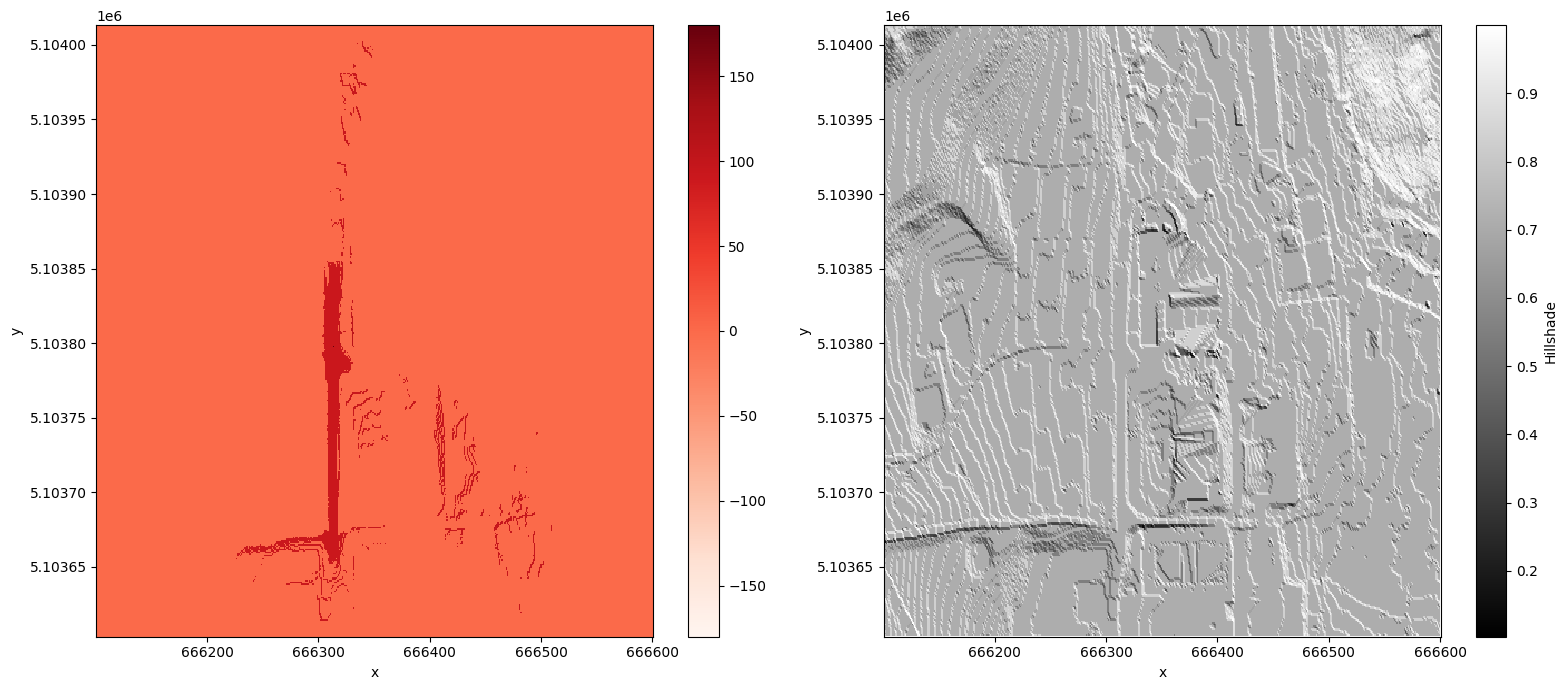

In [594]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 7))
viewshed_grid.plot.imshow(ax=ax1, cmap='Reds')
illuminated.plot.imshow(ax=ax2, cmap='gray')
plt.tight_layout()

In [595]:
df_raster_visibility = raster_visibility.to_dataframe("viewsheed_grid").reset_index()

In [596]:
df_raster_visibility = df_raster_visibility[df_raster_visibility['viewsheed_grid'] == 1]

In [597]:
df_raster_visibility.shape

(4508, 3)

In [598]:
gdf_raster_visibles = gpd.GeoDataFrame(
    df_raster_visibility['viewsheed_grid'],geometry=gpd.points_from_xy(df_raster_visibility.x,df_raster_visibility.y),crs=raster.crs.split("=")[1])

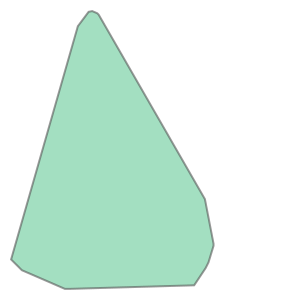

In [599]:
gdf_raster_visibles.unary_union.convex_hull

In [600]:
gdf_raster_visibles['geometry'] = gdf_raster_visibles.geometry.buffer(1).envelope

In [601]:
gdf_raster_visibles.dissolve().explore()